## 1. 环境配置与数据加载

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib as mpl

# 设置中文字体（根据你的系统修改，如黑体 SimHei 或 Arial Unicode MS）
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 加载数据
file_path = r'output\backups\backup_final_04334_retry_final.xlsx'
df = pd.read_excel(file_path)

print(f"原始数据读取成功，共 {len(df)} 行记录。")
# 预览关键列
df[['alien_species', 'times_clean', 'lng', 'lat']].head()

原始数据读取成功，共 4334 行记录。


,alien_species,times_clean,lng,lat
0,三叶鬼针草,2020-10,113.361597,23.124817
1,三叶鬼针草,2019-01,119.470186,32.198285
2,三叶鬼针草,2017-12,113.361597,23.124817
3,三叶鬼针草,2016-12,115.458671,38.877318
4,"三叶鬼针草, 鬼针草",2013-07,113.361597,23.124817


## 2. 数据清洗与长格式转换

## 3. 物种分布统计（确定后续分析策略）

修正后，共得到 5505 条【物种-时空】有效记录。
涵盖物种总数: 38
    sp_name  count        suggested_method
3      互花米草    852  Ripley's K + KDE (大样本)
29      野燕麦    765  Ripley's K + KDE (大样本)
21     紫茎泽兰    597  Ripley's K + KDE (大样本)
20    空心莲子草    412  Ripley's K + KDE (大样本)
28       豚草    363  Ripley's K + KDE (大样本)
13  加拿大一枝黄花    350  Ripley's K + KDE (大样本)
26      薇甘菊    331  Ripley's K + KDE (大样本)
2     三裂叶豚草    270  Ripley's K + KDE (大样本)
33      飞机草    247  Ripley's K + KDE (大样本)
7       假高粱    165  Ripley's K + KDE (大样本)
1     三叶鬼针草    114  Ripley's K + KDE (大样本)
5       假臭草    112  Ripley's K + KDE (大样本)
34      马缨丹     90        最近邻 + 简单聚类 (小样本)
4      五爪金龙     84        最近邻 + 简单聚类 (小样本)
37      黄顶菊     76        最近邻 + 简单聚类 (小样本)
16      小蓬草     73        最近邻 + 简单聚类 (小样本)
27      藿香蓟     60        最近邻 + 简单聚类 (小样本)
35      鬼针草     55        最近邻 + 简单聚类 (小样本)
23      胜红蓟     53        最近邻 + 简单聚类 (小样本)
11       刺苋     44        最近邻 + 简单聚类 (小样本)
30      银胶菊     42        最近邻 + 简单聚类 (小样本)
19      水葫芦     

C:\Users\lincaicai\AppData\Local\Temp\ipykernel_7336\2826004516.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=species_counts.head(15), x='count', y='sp_name', palette='viridis')


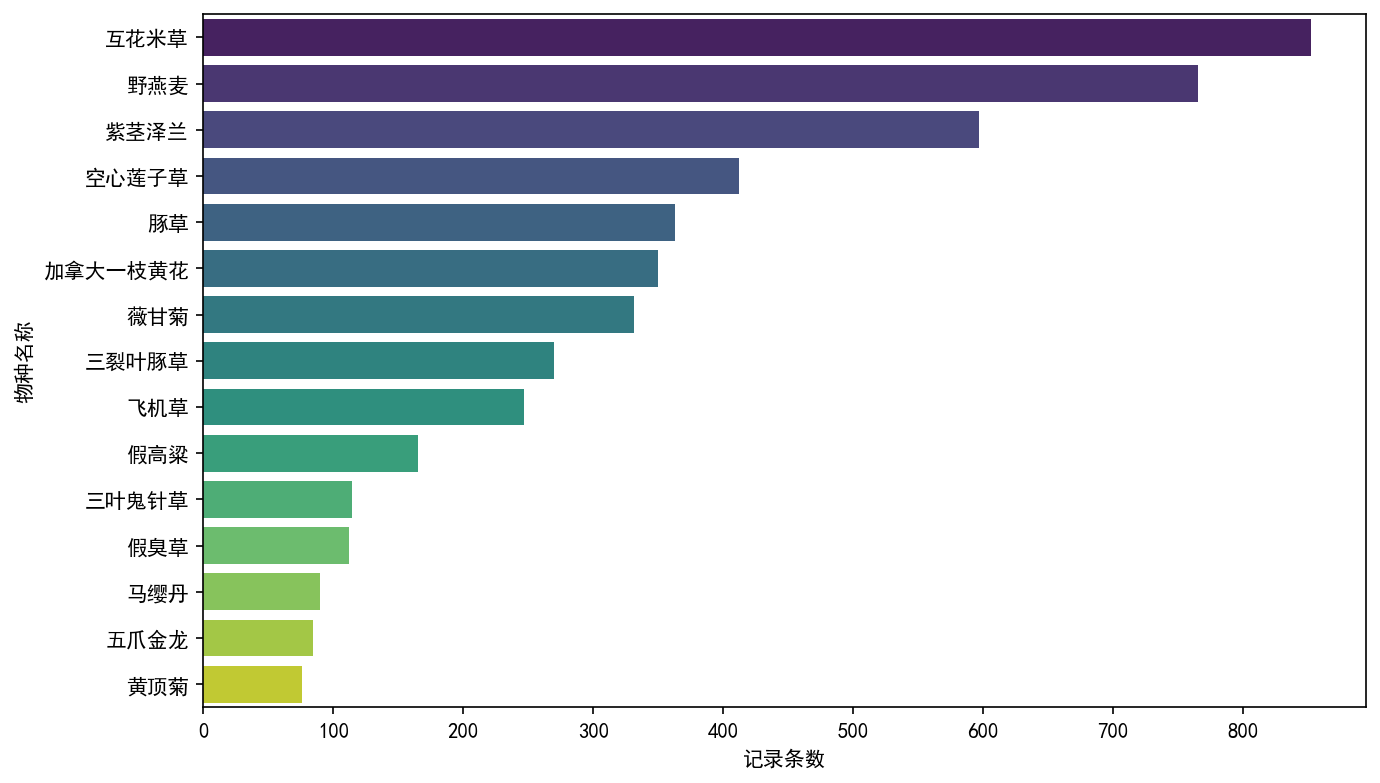

In [23]:
# 1. 转换时间格式
df['year'] = pd.to_datetime(df['times_clean'], errors='coerce').dt.year

# 2. 处理物种字段：使用 alien_species 作为源，重命名为 sp_name 以避免冲突
# 考虑到 alien_species 可能是 NaN，先填充为空字符串
df['species_list'] = df['alien_species'].fillna('').astype(str).apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

# 3. 炸裂数据：一物种一行
df_exploded = df.explode('species_list')

# 4. 彻底重命名该列，确保没有重名冲突
df_exploded = df_exploded.rename(columns={'species_list': 'sp_name'})

# 5. 过滤掉经纬度缺失、时间缺失或物种名为空的无效数据
# 注意：这里我们要确保 lng, lat 是数值型
df_exploded['lng'] = pd.to_numeric(df_exploded['lng'], errors='coerce')
df_exploded['lat'] = pd.to_numeric(df_exploded['lat'], errors='coerce')

df_clean = df_exploded.dropna(subset=['lng', 'lat', 'year', 'sp_name']).copy()
# 排除掉 sp_name 为空字符串的情况
df_clean = df_clean[df_clean['sp_name'] != '']

print(f"修正后，共得到 {len(df_clean)} 条【物种-时空】有效记录。")
print(f"涵盖物种总数: {df_clean['sp_name'].nunique()}")

# --- 统计与分类建议 ---

# 统计每个物种的记录数 (使用 sp_name)
species_counts = df_clean.groupby('sp_name').size().reset_index(name='count')
species_counts = species_counts.sort_values(by='count', ascending=False)

# 分类标准
def suggest_method(count):
    if count >= 100:
        return 'Ripley\'s K + KDE (大样本)'
    else:
        return '最近邻 + 简单聚类 (小样本)'

species_counts['suggested_method'] = species_counts['count'].apply(suggest_method)

# 打印前 20 名物种
# print("\n前20名高频物种及分析策略建议：")
print(species_counts)

# 可视化前15个物种
plt.figure(figsize=(10, 6))
sns.barplot(data=species_counts.head(15), x='count', y='sp_name', palette='viridis')
# plt.title('Top 15 入侵物种记录频率')
plt.xlabel('记录条数')
plt.ylabel('物种名称')
plt.show()

## 4. 时间趋势分析（10年分段）

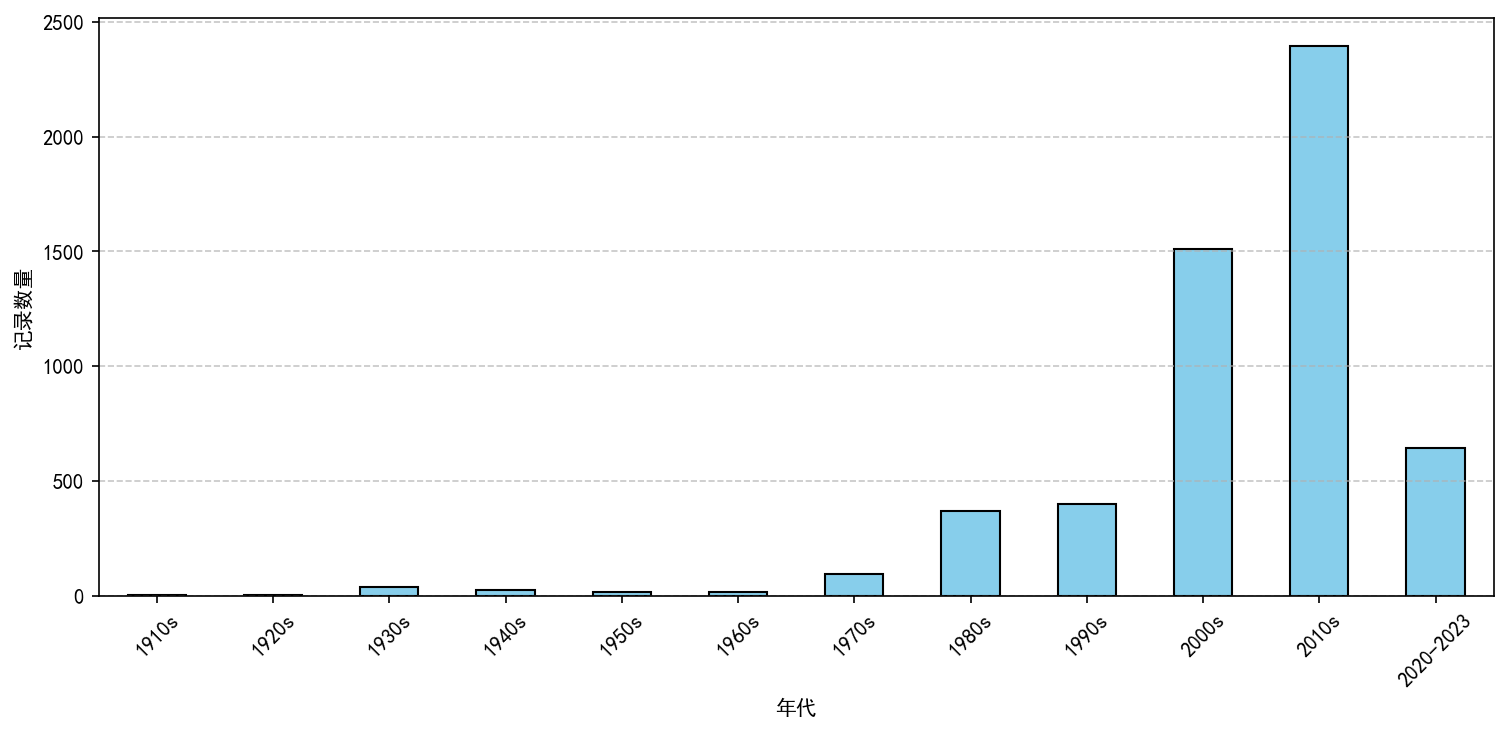

年代数据分布详情：
decade
1910s           1
1920s           1
1930s          38
1940s          26
1950s          15
1960s          14
1970s          93
1980s         368
1990s         400
2000s        1509
2010s        2397
2020-2023     643
dtype: int64


In [14]:
# 设置时间分段（10年一跨度）
# 针对 1911-2023，我们可以定义 bins
bins = list(range(1910, 2030, 10)) + [2024]
labels = [f"{i}s" for i in range(1910, 2020, 10)] + ["2020-2023"]

df_clean['decade'] = pd.cut(df_clean['year'], bins=bins, labels=labels, right=False)

# 按年代统计记录数
temporal_trend = df_clean.groupby('decade', observed=False).size()

plt.figure(figsize=(12, 5))
temporal_trend.plot(kind='bar', color='skyblue', edgecolor='black')
# plt.title('入侵物种记录年代分布 (1911-2023)')
plt.xlabel('年代')
plt.ylabel('记录数量')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("年代数据分布详情：")
print(temporal_trend)

## 5. 空间分布初步概览

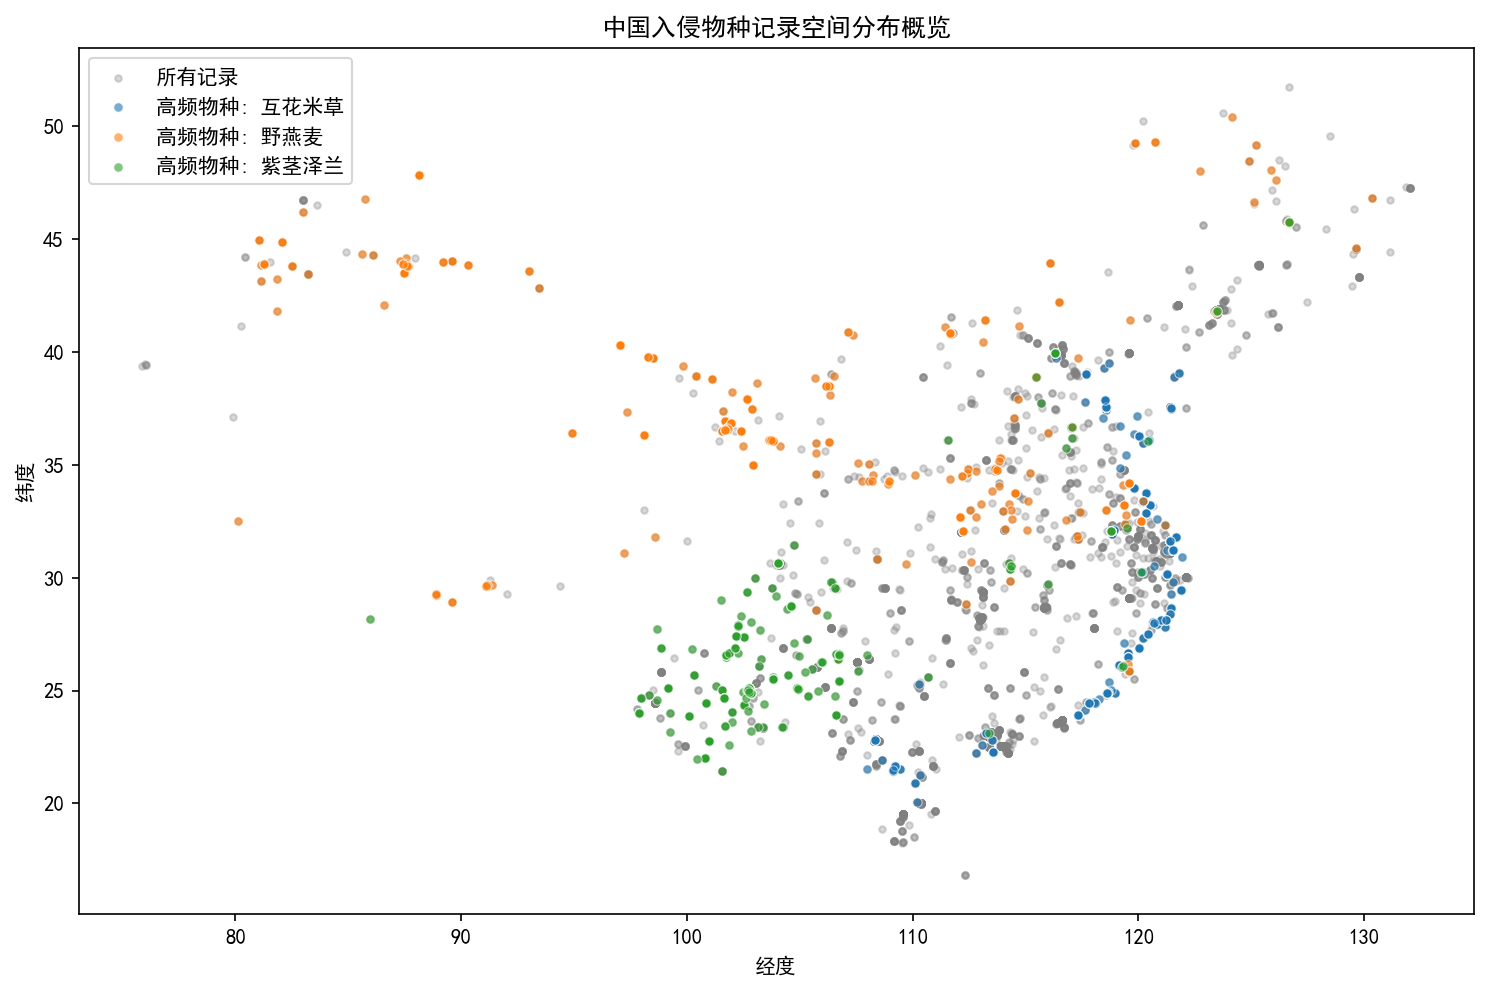

In [15]:
plt.figure(figsize=(12, 8))

# 绘制所有点的底色
plt.scatter(df_clean['lng'], df_clean['lat'], s=10, alpha=0.3, color='gray', label='所有记录')

# 突出显示记录数最多的前3个物种
top_3_species = species_counts['sp_name'].head(3).tolist()
colors = ['red', 'blue', 'green']

for sp, color in zip(top_3_species, colors):
    subset = df_clean[df_clean['species'] == sp]
    plt.scatter(subset['lng'], subset['lat'], s=20, alpha=0.6, label=f'高频物种: {sp}', edgecolors='white', linewidth=0.5)

plt.title('中国入侵物种记录空间分布概览')
plt.xlabel('经度')
plt.ylabel('纬度')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 【阶段1】 聚集性检验 (Ripley's K 函数)

## 6. 针对高频物种的 Ripley's K 检验

正在对 互花米草 进行 Ripley's K 检验，样本数: 852...


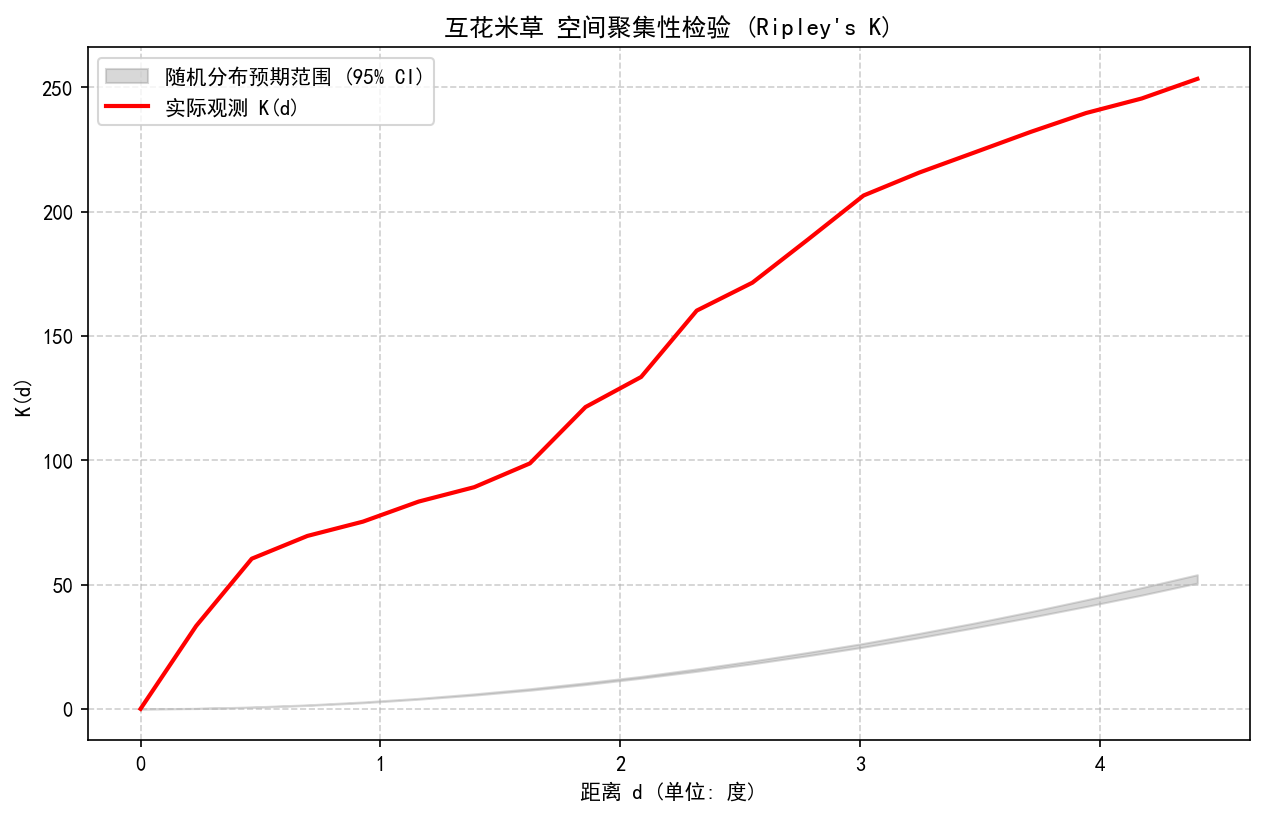

【结论】: 互花米草 呈现显著的【聚集分布】。
在距离约 4.41 度处聚集程度达到峰值。


In [16]:
from pointpats import PointPattern
from pointpats.distance_statistics import k_test
import numpy as np

# 1. 选择分析对象：记录数最多的物种
# 建议先运行 species_counts.head(1) 确认排名第一的准确名称
target_species = "互花米草" 
df_sp = df_clean[df_clean['sp_name'] == target_species].copy()

# 2. 准备空间点数据 (lng, lat)
points = df_sp[['lng', 'lat']].values

print(f"正在对 {target_species} 进行 Ripley's K 检验，样本数: {len(points)}...")

# 3. 执行 K 函数检验
# n_simulations: 蒙特卡洛模拟次数（建议99次以获得95%置信区间）
# dists: 距离序列的数量
# 这里的 support 参数决定了计算的距离范围
k_results = k_test(points, keep_simulations=True, n_simulations=99)

# 4. 可视化
plt.figure(figsize=(10, 6))

# k_results.support 是距离轴 (d)
# k_results.statistic 是实际观测的 K 值
# k_results.simulations 是模拟产生的 K 值矩阵
support = k_results.support
obs_k = k_results.statistic
sims = k_results.simulations

# 计算包络线（置信区间）
lower_bound = np.percentile(sims, 2.5, axis=0)
upper_bound = np.percentile(sims, 97.5, axis=0)

# 绘制包络线
plt.fill_between(support, lower_bound, upper_bound, color='gray', alpha=0.3, label='随机分布预期范围 (95% CI)')
# 绘制观测曲线
plt.plot(support, obs_k, color='red', linewidth=2, label='实际观测 K(d)')

plt.title(f'{target_species} 空间聚集性检验 (Ripley\'s K)')
plt.xlabel('距离 d (单位: 度)')
plt.ylabel('K(d)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. 结论判断
# 找到偏离最大的地方
max_diff_idx = np.argmax(obs_k - upper_bound)
peak_dist = support[max_diff_idx]

if obs_k[max_diff_idx] > upper_bound[max_diff_idx]:
    print(f"【结论】: {target_species} 呈现显著的【聚集分布】。")
    print(f"在距离约 {peak_dist:.2f} 度处聚集程度达到峰值。")
else:
    print(f"【结论】: {target_species} 在当前空间尺度下分布接近随机。")

正在对 野燕麦 进行 Ripley's K 检验，样本数: 765...


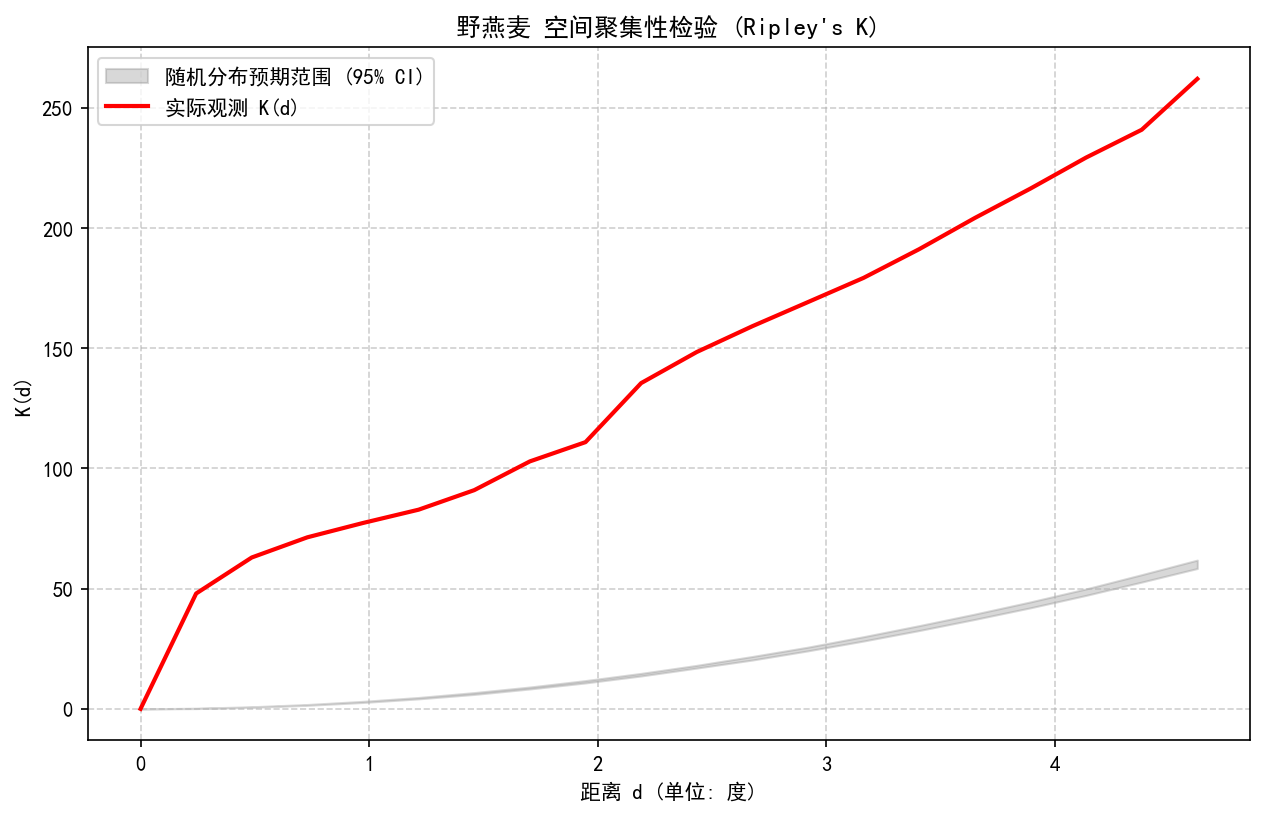

【结论】: 野燕麦 呈现显著的【聚集分布】。
在距离约 4.62 度处聚集程度达到峰值。


In [17]:
from pointpats import PointPattern
from pointpats.distance_statistics import k_test
import numpy as np

# 1. 选择分析对象：记录数最多的物种
# 建议先运行 species_counts.head(1) 确认排名第一的准确名称
target_species = "野燕麦" 
df_sp = df_clean[df_clean['sp_name'] == target_species].copy()

# 2. 准备空间点数据 (lng, lat)
points = df_sp[['lng', 'lat']].values

print(f"正在对 {target_species} 进行 Ripley's K 检验，样本数: {len(points)}...")

# 3. 执行 K 函数检验
# n_simulations: 蒙特卡洛模拟次数（建议99次以获得95%置信区间）
# dists: 距离序列的数量
# 这里的 support 参数决定了计算的距离范围
k_results = k_test(points, keep_simulations=True, n_simulations=99)

# 4. 可视化
plt.figure(figsize=(10, 6))

# k_results.support 是距离轴 (d)
# k_results.statistic 是实际观测的 K 值
# k_results.simulations 是模拟产生的 K 值矩阵
support = k_results.support
obs_k = k_results.statistic
sims = k_results.simulations

# 计算包络线（置信区间）
lower_bound = np.percentile(sims, 2.5, axis=0)
upper_bound = np.percentile(sims, 97.5, axis=0)

# 绘制包络线
plt.fill_between(support, lower_bound, upper_bound, color='gray', alpha=0.3, label='随机分布预期范围 (95% CI)')
# 绘制观测曲线
plt.plot(support, obs_k, color='red', linewidth=2, label='实际观测 K(d)')

plt.title(f'{target_species} 空间聚集性检验 (Ripley\'s K)')
plt.xlabel('距离 d (单位: 度)')
plt.ylabel('K(d)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. 结论判断
# 找到偏离最大的地方
max_diff_idx = np.argmax(obs_k - upper_bound)
peak_dist = support[max_diff_idx]

if obs_k[max_diff_idx] > upper_bound[max_diff_idx]:
    print(f"【结论】: {target_species} 呈现显著的【聚集分布】。")
    print(f"在距离约 {peak_dist:.2f} 度处聚集程度达到峰值。")
else:
    print(f"【结论】: {target_species} 在当前空间尺度下分布接近随机。")

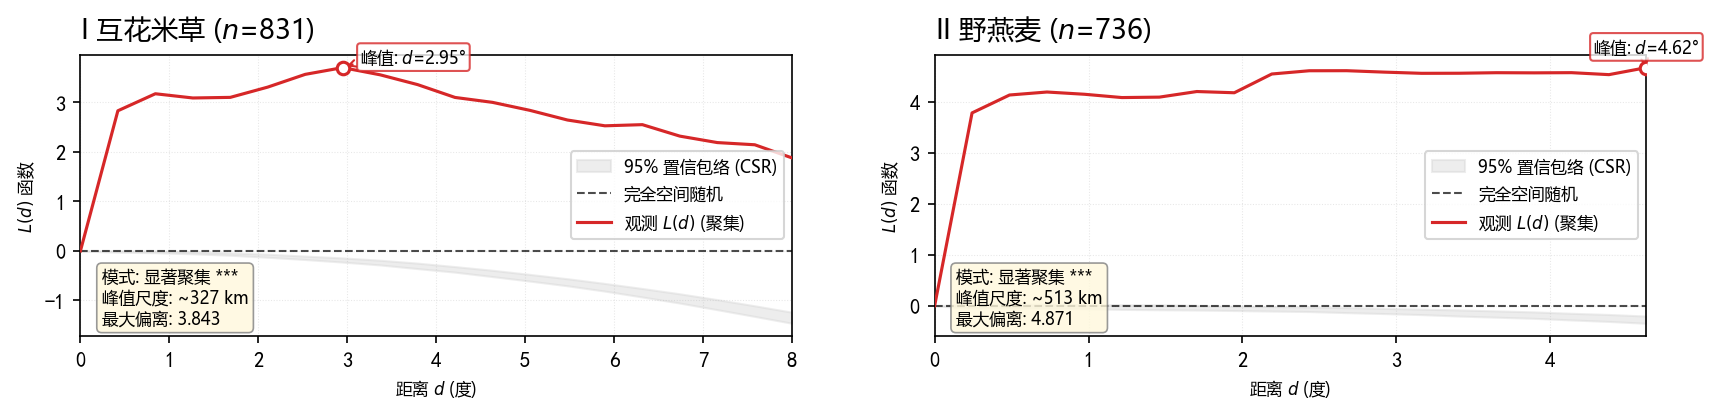

指标                      互花米草                 野燕麦         
-------------------------------------------------------
记录数                     831                  736         
分布模式                    显著聚集                 显著聚集        
显著性                     ***                  ***         
峰值(km)                  327                  513         


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from pointpats import PointPattern
from pointpats.distance_statistics import k_test

try:
    cn_font = fm.FontProperties(fname="C:/Windows/Fonts/msyh.ttc")
except:
    try:
        cn_font = fm.FontProperties(fname="C:/Windows/Fonts/simhei.ttf")
    except:
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
        plt.rcParams['axes.unicode_minus'] = False
        cn_font = fm.FontProperties()

try:
    en_font = fm.FontProperties(fname="C:/Windows/Fonts/consola.ttf")
except:
    en_font = fm.FontProperties(family='monospace')

plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 300

def analyze_species_k_function(df_clean, species_name, ax, panel_label):
    legend_font = cn_font.copy()
    legend_font.set_size(8)
    df_sp = df_clean[df_clean['alien_species'] == species_name].copy()
    points = df_sp[['lng', 'lat']].values
    n_points = len(points)
    
    k_results = k_test(points, keep_simulations=True, n_simulations=99)
    support = k_results.support
    obs_k = k_results.statistic
    sims = k_results.simulations
    
    lower_bound = np.percentile(sims, 2.5, axis=0)
    upper_bound = np.percentile(sims, 97.5, axis=0)
    
    obs_l = np.sqrt(obs_k / np.pi) - support
    lower_l = np.sqrt(lower_bound / np.pi) - support
    upper_l = np.sqrt(upper_bound / np.pi) - support
    
    exceed_upper = np.sum(obs_k > upper_bound) / len(support)
    deviation_upper = obs_l - upper_l
    max_deviation_idx = np.argmax(np.abs(deviation_upper))
    max_deviation = deviation_upper[max_deviation_idx]
    peak_distance = support[max_deviation_idx]
    
    ax.fill_between(support, lower_l, upper_l, color='lightgray', alpha=0.4, label='95% 置信包络 (CSR)', zorder=1)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7, label='完全空间随机', zorder=2)
    
    if max_deviation > 0:
        color = '#d62728'
        pattern_type = '聚集'
    else:
        color = '#1f77b4'
        pattern_type = '规则'
    
    ax.plot(support, obs_l, color=color, linewidth=1.5, label=f'观测 $L(d)$ ({pattern_type})', zorder=3)
    
    if abs(max_deviation) > 0.02:
        ax.plot(peak_distance, obs_l[max_deviation_idx], 'o', color=color, markersize=6, markerfacecolor='white', markeredgewidth=1.5, zorder=4)
        
        y_position = obs_l[max_deviation_idx]
        if peak_distance < support[-1] / 2:
            ha = 'left'
            offset_x = peak_distance + 0.2
            offset_y = y_position
        else:
            ha = 'center'
            offset_x = peak_distance
            offset_y = y_position + 0.2
        
        ax.annotate(f'峰值: $d$={peak_distance:.2f}°', xy=(peak_distance, y_position), xytext=(offset_x, offset_y),
                   ha=ha, va='bottom', fontproperties=cn_font, fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=color, linewidth=1, alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color=color, lw=1, connectionstyle='arc3,rad=0.1'))
    
    ax.set_xlabel('距离 $d$ (度)', fontproperties=cn_font, fontsize=8)
    ax.set_ylabel('$L(d)$ 函数', fontproperties=cn_font, fontsize=8)
    
    title_text = f'{panel_label} {species_name} ($n$={n_points:,})'
    ax.set_title(title_text, fontproperties=cn_font, fontsize=13, fontweight='bold', loc='left', pad=8)

    legend = ax.legend(loc='center right', frameon=True, prop=legend_font)
    legend.set_zorder(10)
    
    ax.grid(True, linestyle=':', alpha=0.3, linewidth=0.5, zorder=0)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
    ax.set_xlim(support[0], support[-1])
    
    if exceed_upper > 0.5: pattern, significance = "显著聚集", "***"
    elif exceed_upper > 0.2: pattern, significance = "中度聚集", "**"
    elif exceed_upper > 0.05: pattern, significance = "弱聚集", "*"
    else: pattern, significance = "随机分布", "n.s."
    
    peak_km = peak_distance * 111
    info_text = f'模式: {pattern} {significance}\n峰值尺度: ~{peak_km:.0f} km\n最大偏离: {max_deviation:.3f}'
    
    ax.text(0.03, 0.03, info_text, transform=ax.transAxes, fontproperties=cn_font, fontsize=8,
            verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF8DC', alpha=0.8, edgecolor='gray', linewidth=0.8), zorder=5)
    
    return {'species': species_name, 'n_points': n_points, 'pattern': pattern, 'significance': significance,
            'peak_distance_km': peak_km, 'max_deviation': max_deviation, 'exceed_upper_pct': exceed_upper}

def create_comparison_plot(df_clean, species1, species2, figsize=(12, 2.5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.patch.set_facecolor('white')
    
    results1 = analyze_species_k_function(df_clean, species1, ax1, 'I')
    results2 = analyze_species_k_function(df_clean, species2, ax2, 'II')
    
    plt.subplots_adjust(wspace=0.2, top=0.9, bottom=0.15, left=0.08, right=0.95)
    plt.savefig('ripleys_k_comparisonII.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"{'指标':<15} {species1:^20} {species2:^20}")
    print("-" * 55)
    print(f"{'记录数':<15} {results1['n_points']:^20,} {results2['n_points']:^20,}")
    print(f"{'分布模式':<15} {results1['pattern']:^20} {results2['pattern']:^20}")
    print(f"{'显著性':<15} {results1['significance']:^20} {results2['significance']:^20}")
    print(f"{'峰值(km)':<15} {results1['peak_distance_km']:^20.0f} {results2['peak_distance_km']:^20.0f}")
    return results1, results2

if __name__ == "__main__":
    df_clean = pd.read_excel(r'output\backups\backup_final_04334_retry_final.xlsx')
    create_comparison_plot(df_clean, "互花米草", "野燕麦")

## 7. 分时段核密度分析 (KDE Heatmap)

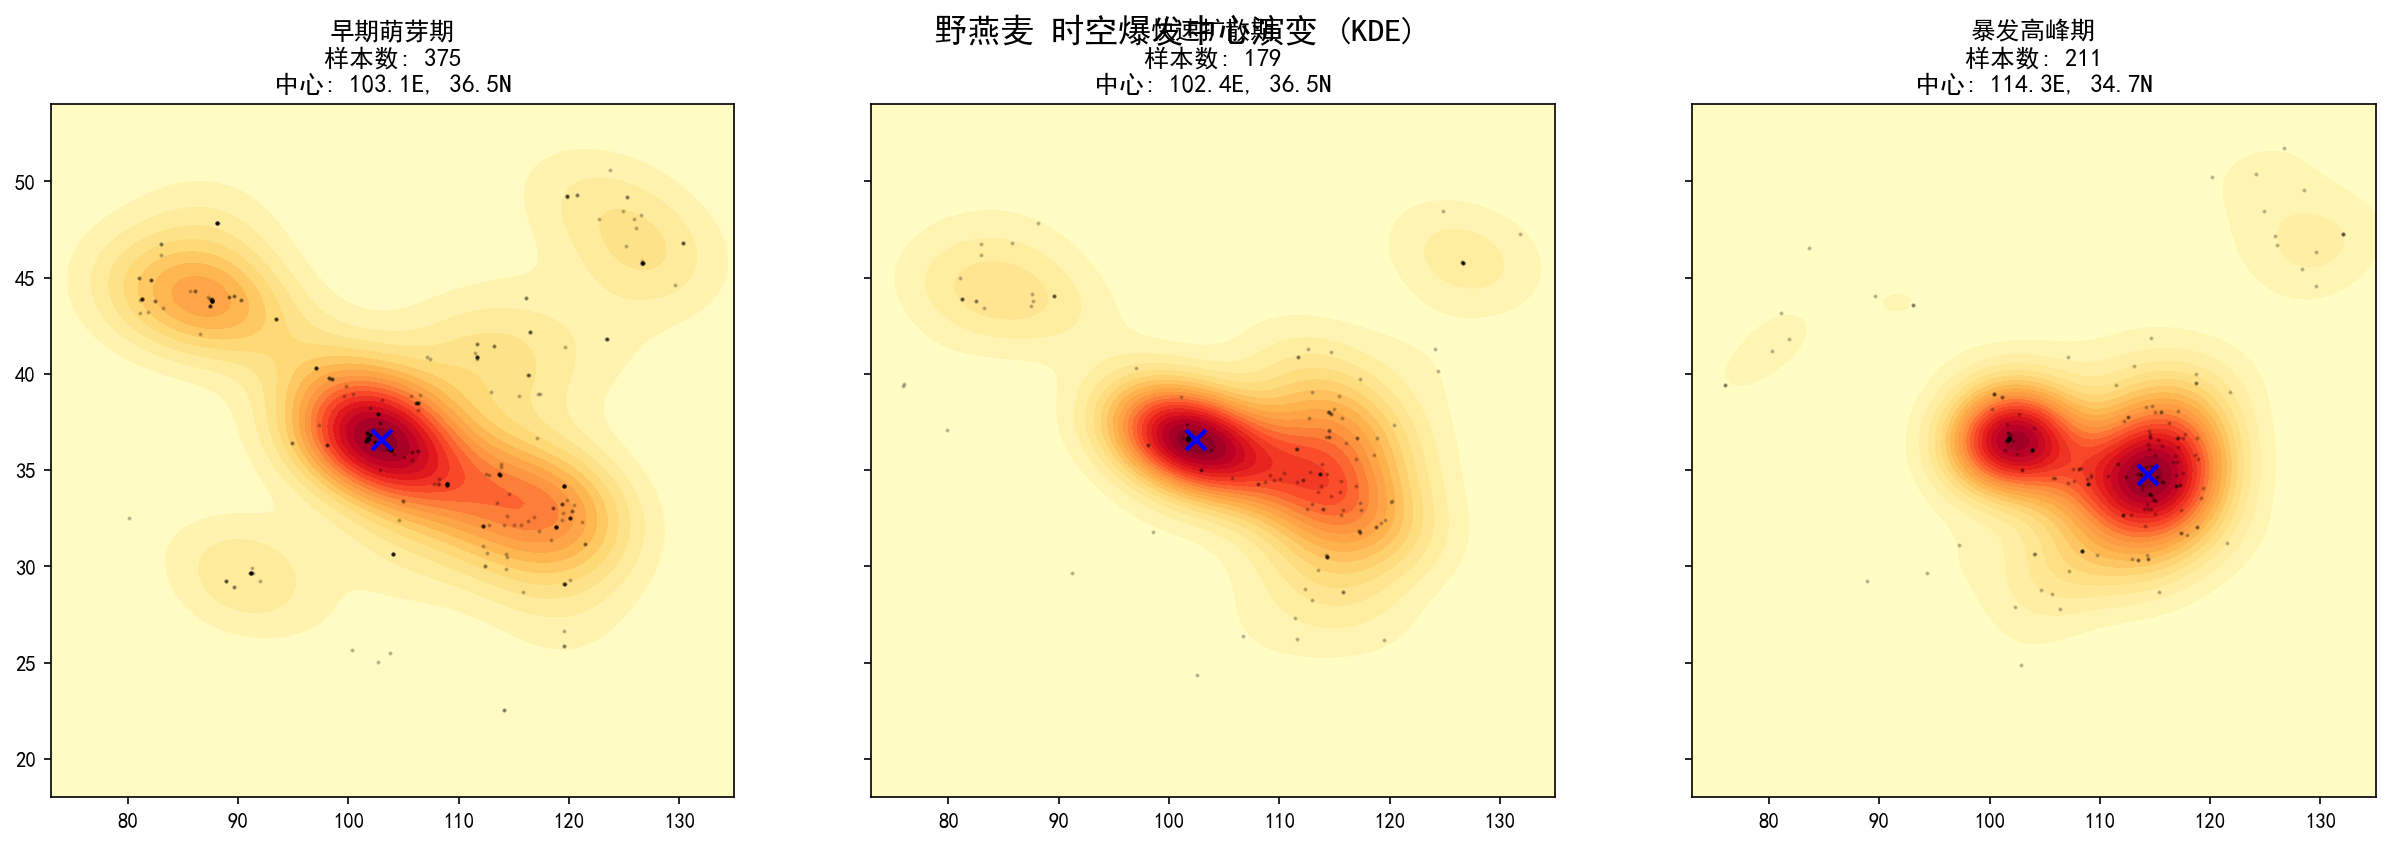

爆发中心迁移轨迹：
早期萌芽期: 经度 103.06, 纬度 36.55
快速扩散期: 经度 102.43, 纬度 36.55
暴发高峰期: 经度 114.33, 纬度 34.73


In [19]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# 1. 定义非均匀时间分段
time_periods = [
    (1911, 1999, "早期萌芽期"),
    (2000, 2010, "快速扩散期"),
    (2011, 2023, "暴发高峰期")
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
centers_info = []

for i, (start, end, title_prefix) in enumerate(time_periods):
    subset = df_sp[(df_sp['year'] >= start) & (df_sp['year'] <= end)]
    
    if len(subset) < 10:
        axes[i].set_title(f"{title_prefix}\n(样本过少: {len(subset)})")
        continue
        
    x = subset['lng'].values
    y = subset['lat'].values
    
    # 构建网格进行密度计算
    xmin, xmax, ymin, ymax = 73, 135, 18, 54
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # 绘图
    cf = axes[i].contourf(xx, yy, f, cmap='YlOrRd', levels=20)
    axes[i].scatter(x, y, s=1, color='black', alpha=0.2)
    
    # 简单的峰值提取：找到密度最大的坐标点
    max_idx = np.argmax(f)
    peak_lng, peak_lat = xx.ravel()[max_idx], yy.ravel()[max_idx]
    axes[i].plot(peak_lng, peak_lat, 'bx', markersize=10, markeredgewidth=2, label='爆发中心')
    
    axes[i].set_title(f"{title_prefix}\n样本数: {len(subset)}\n中心: {peak_lng:.1f}E, {peak_lat:.1f}N")
    centers_info.append((title_prefix, peak_lng, peak_lat))

plt.suptitle(f"{target_species} 时空爆发中心演变 (KDE)", fontsize=16)
plt.show()

# 打印中心迁移路径
print("爆发中心迁移轨迹：")
for info in centers_info:
    print(f"{info[0]}: 经度 {info[1]:.2f}, 纬度 {info[2]:.2f}")

NameError: name 'cn_font_8' is not defined

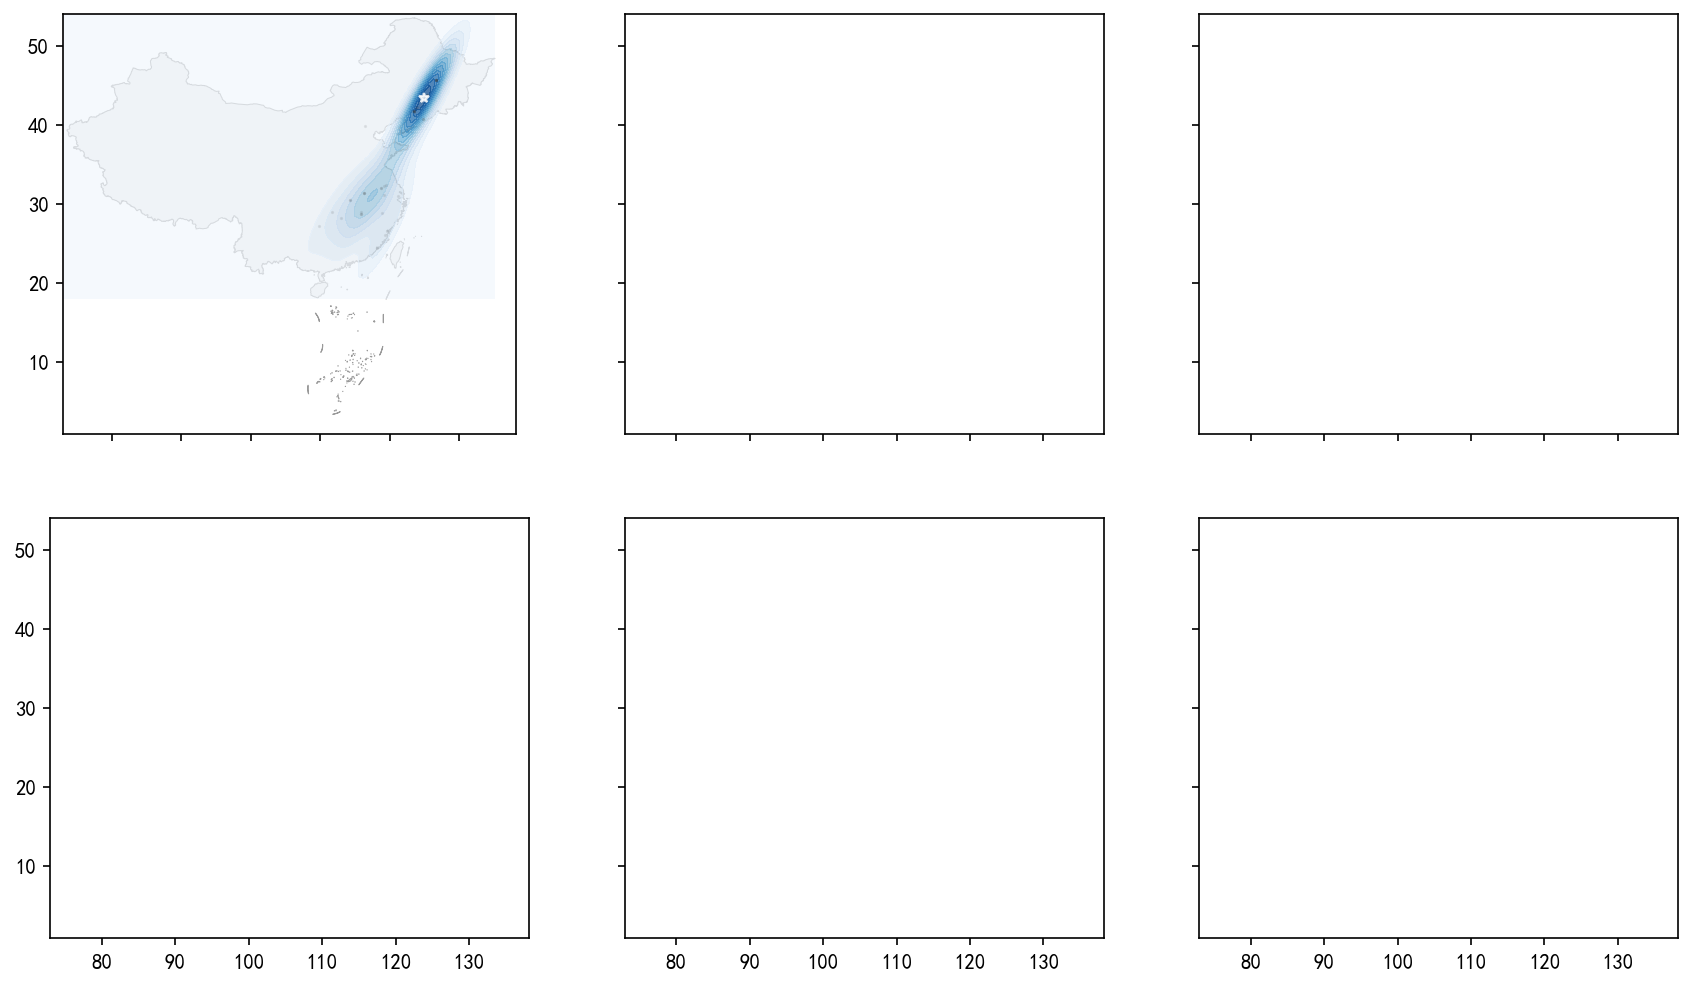

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import gaussian_kde
import geopandas as gpd

# 字体配置 (保持你之前的配置)
try:
    cn_font_13 = fm.FontProperties(fname="C:/Windows/Fonts/msyh.ttc", size=13)
    cn_font_10 = fm.FontProperties(fname="C:/Windows/Fonts/msyh.ttc", size=10)
except:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    cn_font_13 = fm.FontProperties(size=13)
    cn_font_8 = fm.FontProperties(size=8)

def draw_combined_kde(df, sp1, sp2, periods):
    # 1. 创建 2x3 画布
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
    fig.patch.set_facecolor('white')
    
    # 2. 获取中国边界数据 (使用内置或在线数据)
    # 如果你有本地的中国地图shp文件，请替换此路径
    china_url = "https://geo.datav.aliyun.com/areas_v3/bound/100000.json"
    try:
        china_map = gpd.read_file(china_url)
    except:
        china_map = None
        print("警告：无法加载在线地图，将仅绘制坐标轴。")

    species_list = [sp1, sp2]
    cmaps = ['Blues', 'YlOrBr']
    xmin, xmax, ymin, ymax = 73, 135, 18, 54

    for row, species in enumerate(species_list):
        df_sp = df[df['alien_species'] == species].copy()
        df_sp['year'] = pd.to_datetime(df_sp['times_clean'], errors='coerce').dt.year
        
        for col, (start, end, label) in enumerate(periods):
            ax = axes[row, col]
            
            # 绘制中国底图
            if china_map is not None:
                china_map.plot(ax=ax, color='#ebebeb', edgecolor='#999999', linewidth=0.5, zorder=0)
            
            # 数据筛选
            subset = df_sp[(df_sp['year'] >= start) & (df_sp['year'] <= end)]
            n = len(subset)
            
            if n >= 10:
                x, y = subset['lng'].values, subset['lat'].values
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
                positions = np.vstack([xx.ravel(), yy.ravel()])
                kernel = gaussian_kde(np.vstack([x, y]))
                f = np.reshape(kernel(positions).T, xx.shape)
                
                # 绘制密度热力图
                ax.contourf(xx, yy, f, cmap=cmaps[row], levels=15, alpha=0.7, zorder=1)
                ax.scatter(x, y, s=0.3, color='#333333', alpha=0.1, zorder=2)
                
                # 提取爆发中心
                max_idx = np.argmax(f)
                px, py = xx.ravel()[max_idx], yy.ravel()[max_idx]
                ax.plot(px, py, marker='*', markersize=5, color='white', alpha=0.8, zorder=3)
                
                # 右下角中心坐标信息 (字号 8)
                center_text = f'{px:.1f}°E, {py:.1f}°N'
                ax.text(0.98, 0.02, center_text, transform=ax.transAxes, 
                        fontproperties=cn_font_8, ha='right', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.6))
            else:
                ax.text(0.5, 0.5, f'样本量不足(n={n})', transform=ax.transAxes, 
                        ha='center', fontproperties=cn_font_8)

            # 设置子图标题 (字号 8)
            ax.set_title(f"{label} (n={n})", fontproperties=cn_font_8)
            
            # 坐标轴设置 (字号 8)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.tick_params(labelsize=8)
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)

    # 设置公共坐标轴标签 (字号 8)
    for i in range(3):
        axes[1, i].set_xlabel('经度 (°)', fontproperties=cn_font_8)
    for i in range(2):
        axes[i, 0].set_ylabel('纬度 (°)', fontproperties=cn_font_8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('combined_kde_mapII.png', dpi=300, bbox_inches='tight')
    plt.show()

# 调用
periods = [
    (1911, 1999, "早期萌芽期"),
    (2000, 2010, "快速扩散期"),
    (2011, 2023, "爆发高峰期")
]

# 确保你的 df_clean 中没有 NaN 年份
draw_combined_kde(df_clean, "豚草", "五爪金龙", periods)

# 【阶段3】扩散动力学分析

## 8. 占据范围扩张 (MCP 最小凸多边形)

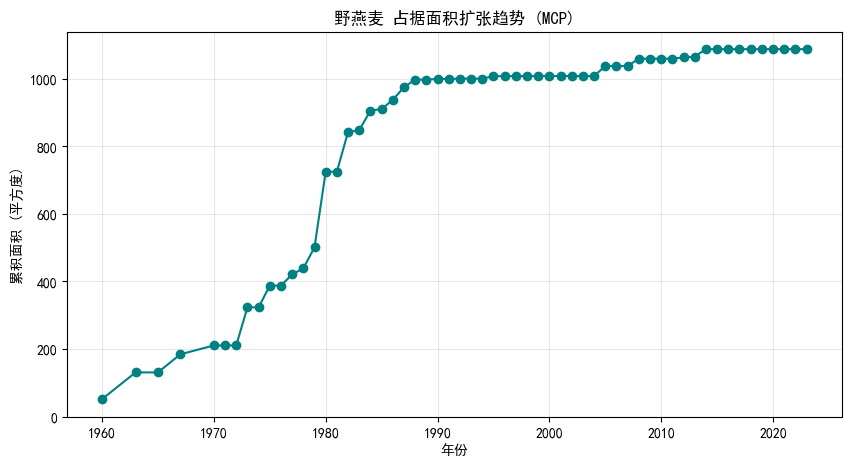

In [ ]:
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np

def calculate_mcp_area(group):
    """计算一组点的凸包面积（单位：平方度，近似值）"""
    if len(group) < 3:
        return 0
    points = group[['lng', 'lat']].values
    # 简单的去重，防止重复点导致算法报错
    points = np.unique(points, axis=0)
    if len(points) < 3: return 0
    
    try:
        hull = ConvexHull(points)
        return hull.volume # 对于2D来说，volume即面积
    except:
        return 0

# 按年累计计算：统计到某一年为止的所有记录所占的面积
years = sorted(df_sp['year'].unique())
area_growth = []

for yr in years:
    current_df = df_sp[df_sp['year'] <= yr]
    area = calculate_mcp_area(current_df)
    area_growth.append({'year': yr, 'cum_area': area})

df_area = pd.DataFrame(area_growth)

# 可视化扩张曲线
plt.figure(figsize=(10, 5))
plt.plot(df_area['year'], df_area['cum_area'], marker='o', linestyle='-', color='teal')
plt.title(f'{target_species} 占据面积扩张趋势 (MCP)')
plt.xlabel('年份')
plt.ylabel('累积面积 (平方度)')
plt.grid(True, alpha=0.3)
plt.show()

## 9. 扩散方向与重心迁移 (SDE 标准差椭圆)

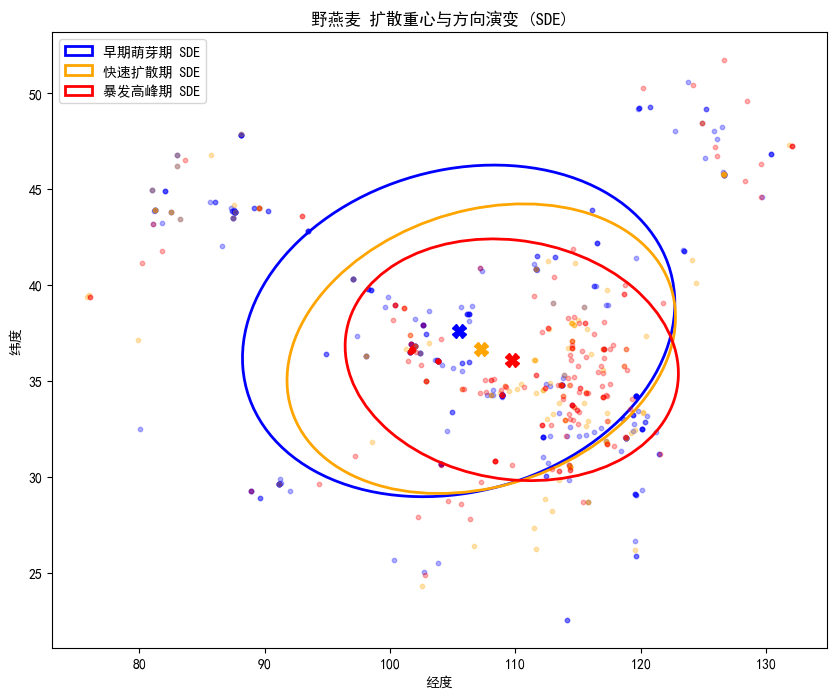

In [ ]:
def get_sde(points):
    """计算标准差椭圆参数"""
    x = points[:, 0]
    y = points[:, 1]
    n = len(points)
    
    # 1. 重心
    center_x, center_y = np.mean(x), np.mean(y)
    
    # 2. 坐标平移
    dx, dy = x - center_x, y - center_y
    
    # 3. 计算旋转角度 theta
    sum_dx2 = np.sum(dx**2)
    sum_dy2 = np.sum(dy**2)
    sum_dx_dy = np.sum(dx * dy)
    
    term1 = (sum_dx2 - sum_dy2)
    term2 = np.sqrt(term1**2 + 4 * (sum_dx_dy**2))
    tan_theta = (term1 + term2) / (2 * sum_dx_dy)
    theta = np.arctan(tan_theta)
    
    # 4. 计算长短轴标准差
    sin_t, cos_t = np.sin(theta), np.cos(theta)
    sigma_x = np.sqrt(2 * np.sum((dx * cos_t + dy * sin_t)**2) / n)
    sigma_y = np.sqrt(2 * np.sum((dy * cos_t - dx * sin_t)**2) / n)
    
    return center_x, center_y, sigma_x, sigma_y, np.degrees(theta)

from matplotlib.patches import Ellipse

# 针对不同时段绘制 SDE
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['blue', 'orange', 'red']
for i, (start, end, label) in enumerate(time_periods):
    subset = df_sp[(df_sp['year'] >= start) & (df_sp['year'] <= end)]
    if len(subset) < 5: continue
    
    pts = subset[['lng', 'lat']].values
    cx, cy, sx, sy, ang = get_sde(pts)
    
    # 绘制原始点
    ax.scatter(pts[:, 0], pts[:, 1], s=10, alpha=0.3, color=colors[i])
    
    # 绘制椭圆 (2倍标准差包含约95%的点)
    ell = Ellipse(xy=(cx, cy), width=sx*2, height=sy*2, angle=ang,
                  edgecolor=colors[i], facecolor='none', lw=2, label=f'{label} SDE')
    ax.add_patch(ell)
    ax.plot(cx, cy, marker='X', color=colors[i], markersize=10) # 重心

ax.set_title(f"{target_species} 扩散重心与方向演变 (SDE)")
ax.set_xlabel("经度")
ax.set_ylabel("纬度")
ax.legend()
plt.show()

## 10. 增长曲线拟合与扩散模式识别

指数模型 R²: 0.6414
Logistic模型 R²: 0.9831

扩散模式判定结果: 【渗透型 (Infiltration)】: 扩张速度先增后减，趋于环境稳定。


e:\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


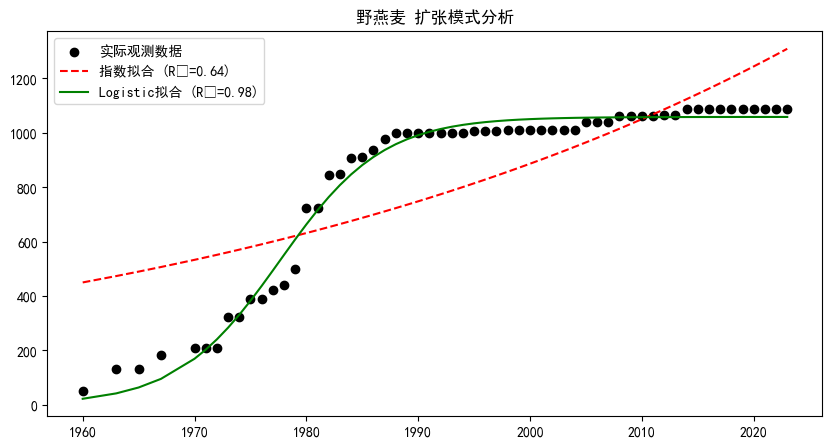

In [ ]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 定义拟合模型
def logistic_model(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def exponential_model(t, a, b):
    return a * np.exp(b * (t - years[0]))

# 准备数据 (归一化时间)
t_data = df_area['year'].values
y_data = df_area['cum_area'].values

try:
    # 尝试指数拟合
    popt_exp, _ = curve_fit(exponential_model, t_data, y_data, p0=[0.1, 0.05])
    y_pred_exp = exponential_model(t_data, *popt_exp)
    r2_exp = r2_score(y_data, y_pred_exp)
    
    # 尝试逻辑斯蒂拟合 (S型曲线)
    popt_log, _ = curve_fit(logistic_model, t_data, y_data, p0=[max(y_data), 0.1, np.median(t_data)])
    y_pred_log = logistic_model(t_data, *popt_log)
    r2_log = r2_score(y_data, y_pred_log)
    
    print(f"指数模型 R²: {r2_exp:.4f}")
    print(f"Logistic模型 R²: {r2_log:.4f}")

    # 模式判别逻辑
    if r2_exp > 0.9 and r2_exp > r2_log:
        mode = "【爆发型 (Explosive)】: 面积呈指数增长，尚未达到环境容纳量。"
    elif r2_log > 0.9:
        mode = "【渗透型 (Infiltration)】: 扩张速度先增后减，趋于环境稳定。"
    else:
        mode = "【跳跃型/不规则型】: 扩张路径不连续，可能存在长距离随机传播。"
    
    print(f"\n扩散模式判定结果: {mode}")

    # 绘图对比
    plt.figure(figsize=(10, 5))
    plt.scatter(t_data, y_data, label='实际观测数据', color='black')
    plt.plot(t_data, y_pred_exp, 'r--', label=f'指数拟合 (R²={r2_exp:.2f})')
    plt.plot(t_data, y_pred_log, 'g-', label=f'Logistic拟合 (R²={r2_log:.2f})')
    plt.title(f'{target_species} 扩张模式分析')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"拟合失败: {e}，可能是因为数据点太少或分布太极端。")

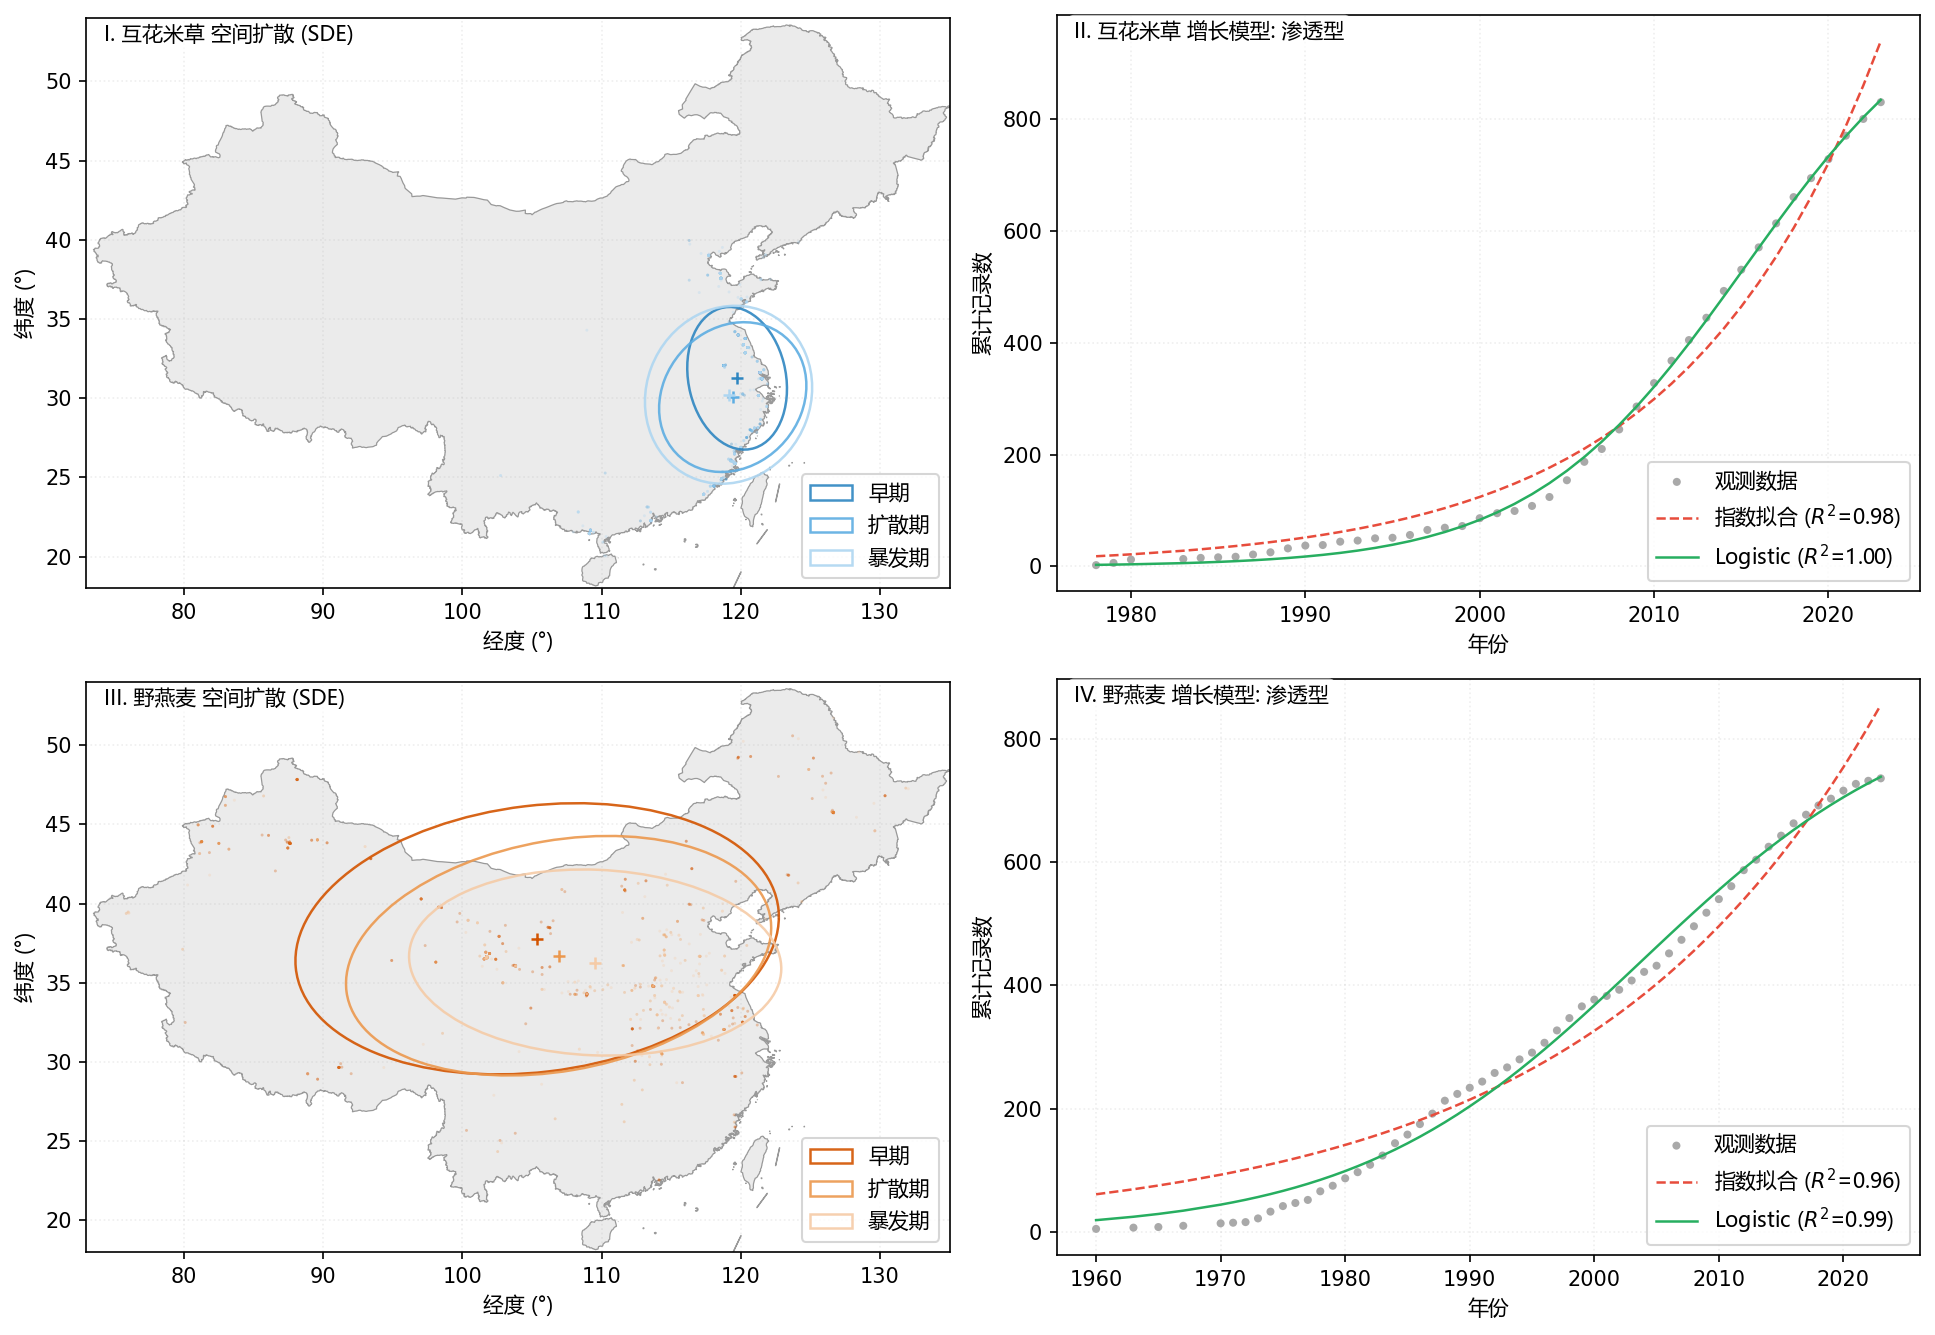

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import geopandas as gpd

# 字体配置 (Title 13, Others 8/10 可调)
cn_font_10 = fm.FontProperties(fname="C:/Windows/Fonts/msyh.ttc", size=10)
# cn_font_8 = fm.FontProperties(fname="C:/Windows/Fonts/msyh.ttc", size=8)

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# 获取中国地图数据
china_url = "https://geo.datav.aliyun.com/areas_v3/bound/100000.json"
try:
    china_map = gpd.read_file(china_url)
except:
    china_map = None

def get_sde(points):
    x, y = points[:, 0], points[:, 1]
    n = len(points)
    center_x, center_y = np.mean(x), np.mean(y)
    dx, dy = x - center_x, y - center_y
    sum_dx2, sum_dy2, sum_dx_dy = np.sum(dx**2), np.sum(dy**2), np.sum(dx * dy)
    term1 = sum_dx2 - sum_dy2
    term2 = np.sqrt(term1**2 + 4 * sum_dx_dy**2)
    tan_theta = (term1 + term2) / (2 * sum_dx_dy)
    theta = np.arctan(tan_theta)
    sin_t, cos_t = np.sin(theta), np.cos(theta)
    sigma_x = np.sqrt(2 * np.sum((dx * cos_t + dy * sin_t)**2) / n)
    sigma_y = np.sqrt(2 * np.sum((dy * cos_t - dx * sin_t)**2) / n)
    return center_x, center_y, sigma_x, sigma_y, np.degrees(theta)

def plot_sde_temporal_with_map(ax, df_sp, periods, colors, species_name):
    # 绘制底图
    if china_map is not None:
        china_map.plot(ax=ax, color='#ebebeb', edgecolor='#999999', linewidth=0.6, zorder=0)
    
    for i, (start, end, label) in enumerate(periods):
        subset = df_sp[(df_sp['year'] >= start) & (df_sp['year'] <= end)]
        if len(subset) < 5: continue
        
        pts = subset[['lng', 'lat']].values
        cx, cy, sx, sy, ang = get_sde(pts)
        
        # 散点
        ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3, color=colors[i], edgecolors='none', zorder=1)
        
        # 椭圆
        ell = Ellipse(xy=(cx, cy), width=sx*2, height=sy*2, angle=ang,
                     edgecolor=colors[i], facecolor='none', lw=1.2, 
                     label=label, alpha=0.9, zorder=2)
        ax.add_patch(ell)
        
        # 重心
        ax.plot(cx, cy, marker='+', color=colors[i], markersize=6, markeredgewidth=1.2, zorder=3)
    
    ax.set_xlim(73, 135)
    ax.set_ylim(18, 54)
    ax.set_xlabel('经度 (°)', fontproperties=cn_font_10)
    ax.set_ylabel('纬度 (°)', fontproperties=cn_font_10)
    ax.legend(prop=cn_font_8, loc='lower right', frameon=True, framealpha=0.8)
    ax.grid(True, linestyle=':', alpha=0.2)
    ax.text(0.02, 0.96, species_name, transform=ax.transAxes, fontproperties=cn_font_10, 
            fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.7))

def logistic_model(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def exponential_model(t, a, b):
    # 为防止溢出，将t归一化处理
    return a * np.exp(b * (t - t[0]))

def plot_diffusion_model(ax, df_sp, species_name):
    # 统计每年新增和累计
    df_area = df_sp.groupby('year').size().cumsum().reset_index()
    df_area.columns = ['year', 'cum_count']
    t_data, y_data = df_area['year'].values, df_area['cum_count'].values
    
    try:
        popt_exp, _ = curve_fit(exponential_model, t_data, y_data, p0=[y_data[0], 0.05], maxfev=5000)
        y_pred_exp = exponential_model(t_data, *popt_exp)
        r2_exp = r2_score(y_data, y_pred_exp)
    except:
        r2_exp, y_pred_exp = 0, None
    
    try:
        popt_log, _ = curve_fit(logistic_model, t_data, y_data, 
                                p0=[max(y_data), 0.1, np.median(t_data)], maxfev=5000)
        y_pred_log = logistic_model(t_data, *popt_log)
        r2_log = r2_score(y_data, y_pred_log)
    except:
        r2_log, y_pred_log = 0, None
    
    ax.scatter(t_data, y_data, s=15, color='#555555', alpha=0.5, label='观测数据', edgecolors='none')
    if y_pred_exp is not None:
        ax.plot(t_data, y_pred_exp, '--', color='#E74C3C', lw=1.2, label=f'指数拟合 ($R^2$={r2_exp:.2f})')
    if y_pred_log is not None:
        ax.plot(t_data, y_pred_log, '-', color='#27AE60', lw=1.2, label=f'Logistic ($R^2$={r2_log:.2f})')
    
    mode = "爆发型" if r2_exp > 0.9 and r2_exp > r2_log else "渗透型" if r2_log > 0.8 else "跳跃型"
    ax.text(0.02, 0.96, f'{species_name}: {mode}', transform=ax.transAxes, 
            fontproperties=cn_font_10, fontweight='bold', bbox=dict(boxstyle='round', fc='white', alpha=0.7, ec='none'))
    ax.set_xlabel('年份', fontproperties=cn_font_10)
    ax.set_ylabel('累计记录数', fontproperties=cn_font_10)
    ax.legend(prop=cn_font_8, loc='lower right')
    ax.grid(True, linestyle=':', alpha=0.2)

def analyze_diffusion_patterns(df, sp1, sp2, periods):
    df['year'] = pd.to_datetime(df['times_clean'], errors='coerce').dt.year
    df1 = df[df['alien_species'] == sp1].copy()
    df2 = df[df['alien_species'] == sp2].copy()
    
    colors1 = ['#2E86C1', '#5DADE2', '#AED6F1']
    colors2 = ['#D35400', '#EB984E', '#F5CBA7']
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.patch.set_facecolor('white')
    
    # 子图 I & II (物种1)
    plot_sde_temporal_with_map(axes[0, 0], df1, periods, colors1, f"I. {sp1} 空间扩散 (SDE)")
    plot_diffusion_model(axes[0, 1], df1, f"II. {sp1} 增长模型")
    
    # 子图 III & IV (物种2)
    plot_sde_temporal_with_map(axes[1, 0], df2, periods, colors2, f"III. {sp2} 空间扩散 (SDE)")
    plot_diffusion_model(axes[1, 1], df2, f"IV. {sp2} 增长模型")
    
    plt.tight_layout()
    plt.savefig('diffusion_combined_analysisII.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行
periods = [(1911, 1999, "早期"), (2000, 2010, "扩散期"), (2011, 2023, "暴发期")]
analyze_diffusion_patterns(df_clean, "互花米草", "野燕麦", periods)